In [1]:
from pathlib import Path

import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
DATA_ROOT = Path('..') / 'data'

### Load data

**Data description**
- Column 1: Time in seconds
- Column 2: Acceleration reading in G for frontal axis
- Column 3: Acceleration reading in G for vertical axis
- Column 4: Acceleration reading in G for lateral axis
- Column 5: Id of antenna reading sensor
- Column 6: Received signal strength indicator (RSSI)
- Column 7: Phase
- Column 8: Frequency
- Column 9: Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

In [3]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
activity_df.to_csv('activity_df.csv')

In [4]:
activity_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.00,1.03420,0.388130,-0.013684,4,-59.5,4.4301,920.75,1,bed,F,d1p57F
1,1.00,0.98728,0.215880,0.088944,4,-65.0,5.8460,923.25,3,lying,F,d1p57F
2,1.25,0.98728,-0.002297,-0.139120,4,-67.0,5.8123,922.25,3,lying,F,d1p57F
3,2.25,0.85830,0.169950,0.043332,3,-48.0,0.2439,921.25,3,lying,F,d1p57F
4,2.30,0.85830,0.169950,0.043332,3,-50.5,1.0600,925.25,3,lying,F,d1p57F


### Get activity boundaries as a data frame

In [5]:
def get_bounds_df(df):
    start = 0
    bounds = []
    last_activity = None
    bound = {}
    for i, row in df.iterrows():
        activity = row['activity']
        if activity != last_activity:
            last_activity = activity
            if bound:
                bounds.append(bound)
                bound = {}
            
            bound = {
                'activity': row['activity'], 
                'activity_label': row['activity_label'], 
                'start_index': i, 
                'start_time': df['time'][i],
            }
        if bound:
            bound['end_index'] = i
            bound['end_time'] = df['time'][i]
              
    if bound:
        bounds.append(bound)
    bounds_df = pd.DataFrame(bounds)
    return bounds_df
                
    

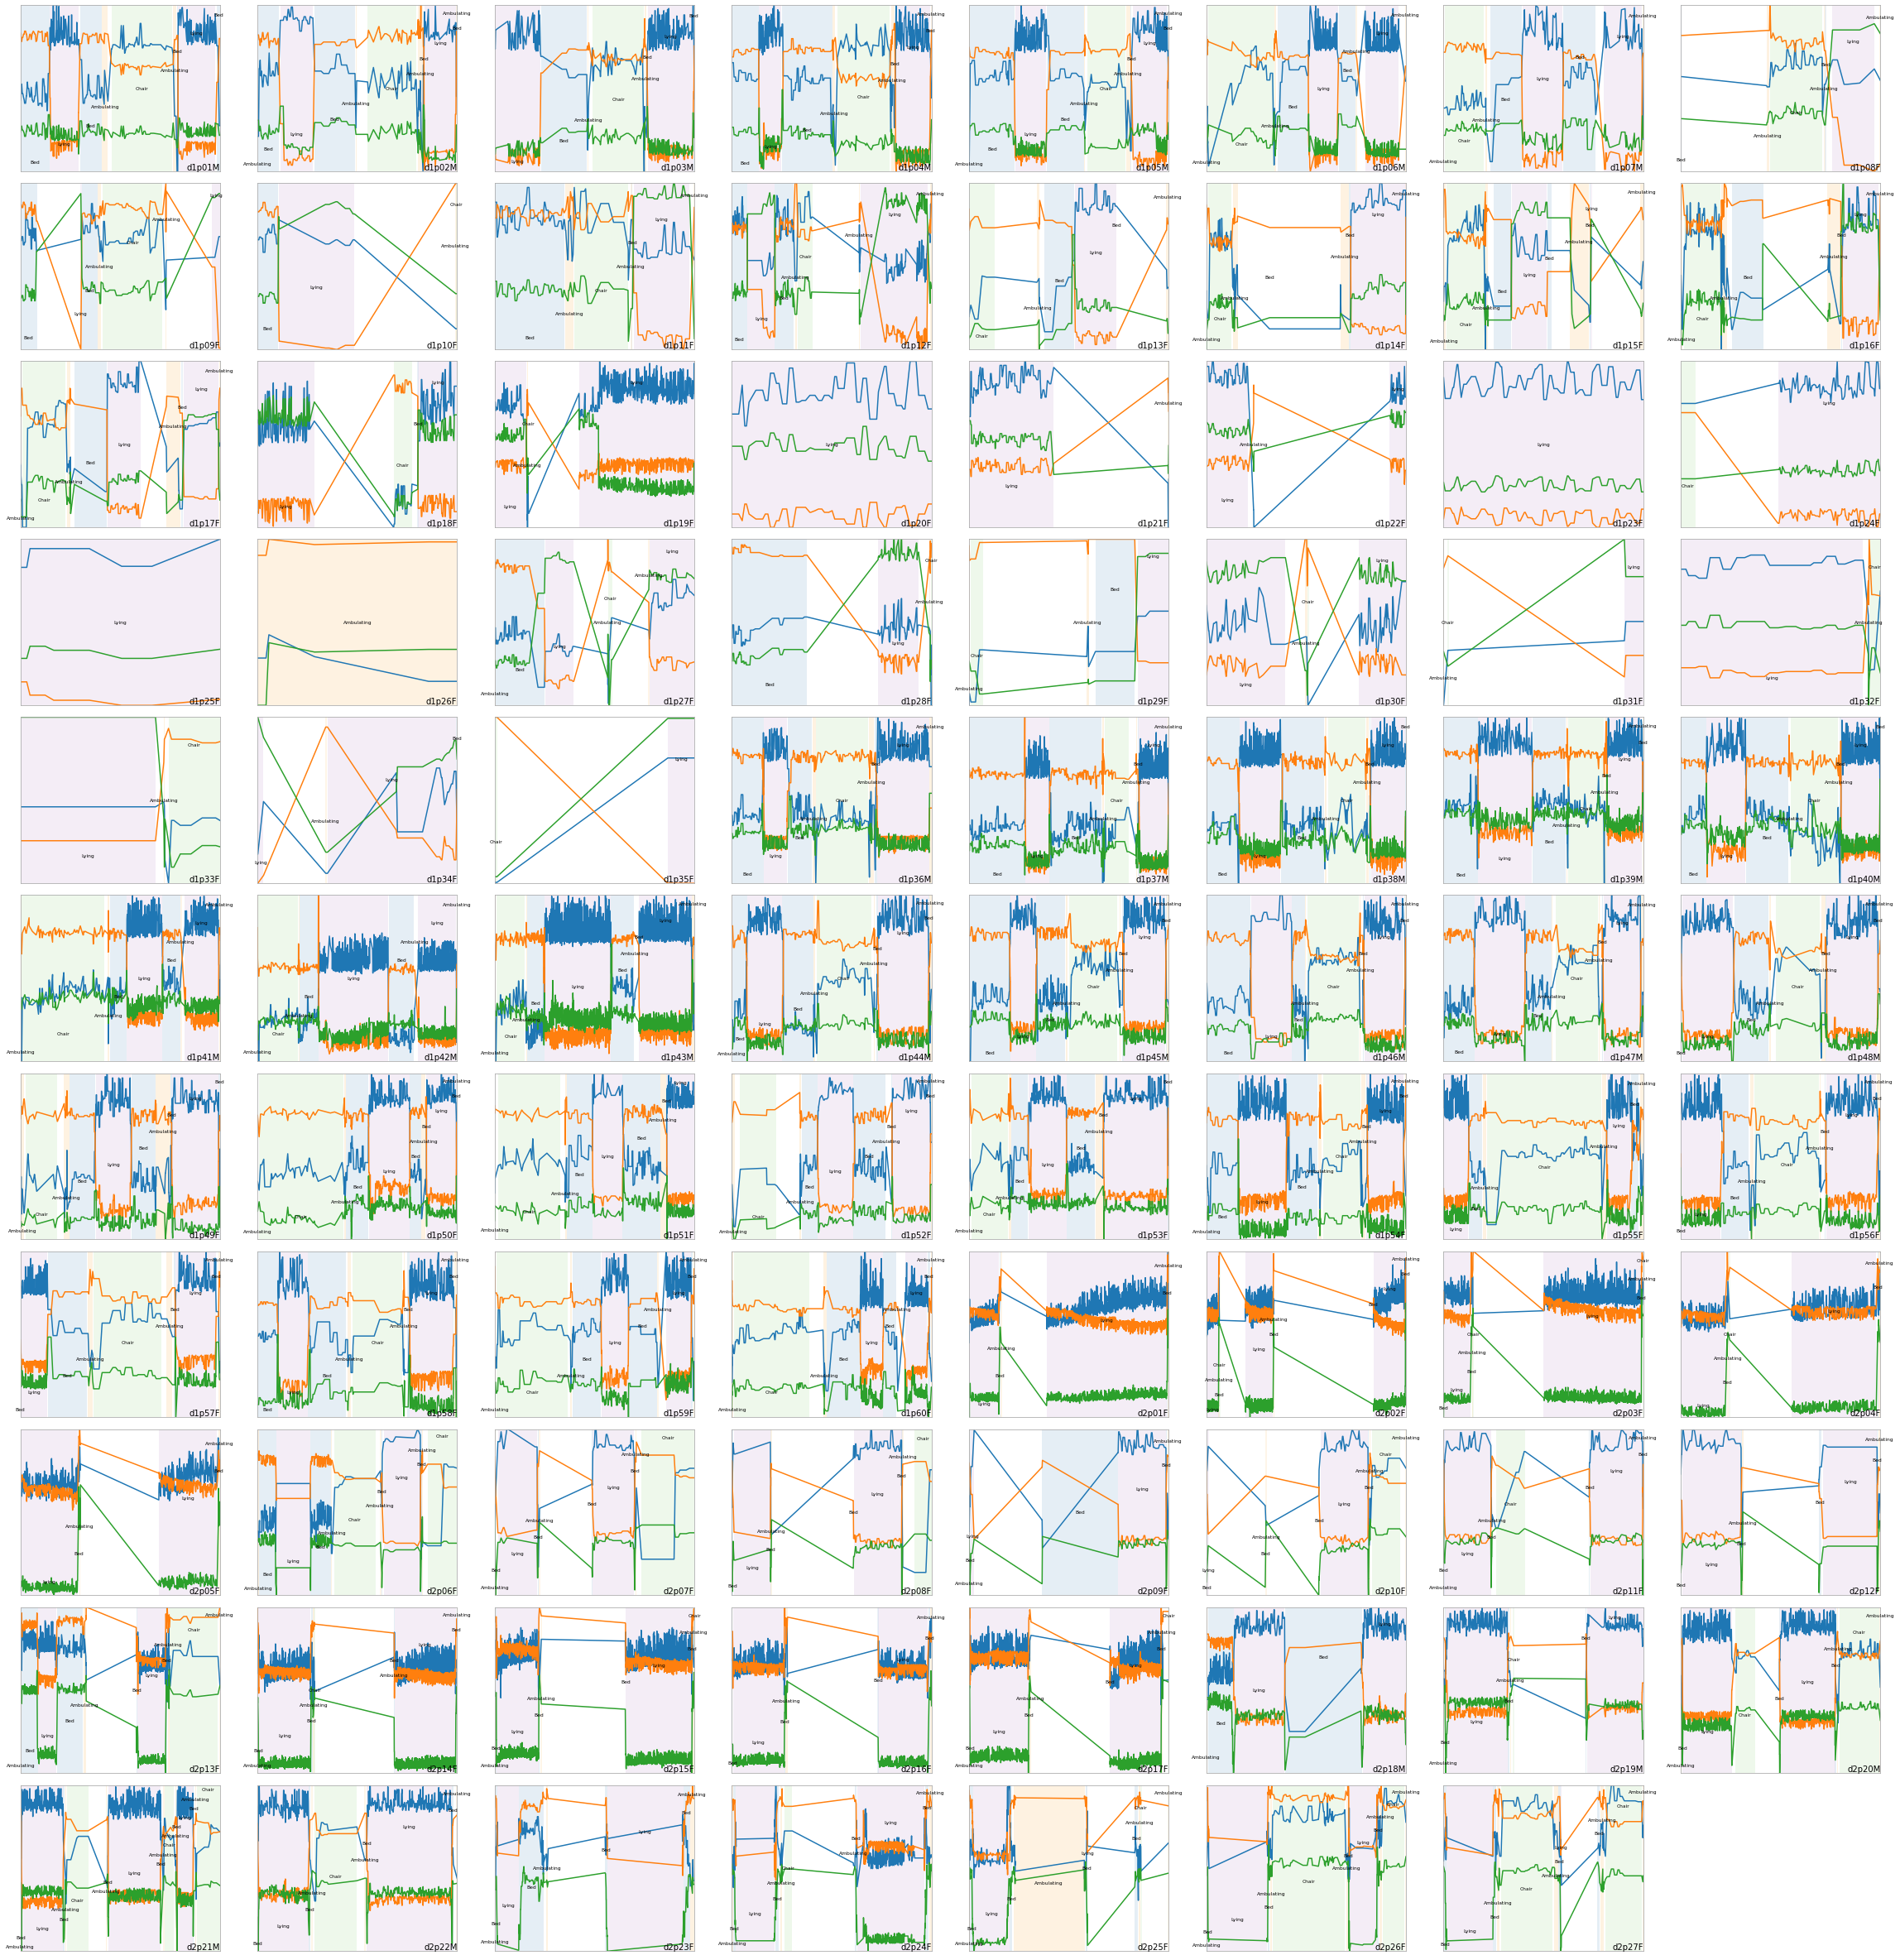

In [6]:
colors = get_cmap('Pastel1').colors
matplotlib.rc('axes', edgecolor='#aaaaaa')

ncols = 8
nrows = np.ceil(activity_df['participant'].nunique() / ncols).astype(int)

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(ncols * 4, nrows * 3),
    sharex=False,
    sharey=False)

for g, group in enumerate(activity_df.groupby(['participant'])):
    participant, df = group
    i = g // ncols
    j = g % ncols
    ax = axs[i][j]
    ax.plot(df['time'], df['front'])
    ax.plot(df['time'], df['vertical'])
    ax.plot(df['time'], df['lateral'])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0, 0, tight=True)
    bounds_df = get_bounds_df(df)
    _, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    height = ymax - ymin
    
    nbounds = len(bounds_df)
    for i, bound in bounds_df.iterrows():
        x = bound['start_time']
        y = ymin
        width = bound['end_time'] - bound['start_time']
        if width:
            rect = mpatches.Rectangle(
                [x, y], 
                width, 
                height, 
                alpha=0.333, 
                color=colors[bound['activity']], 
                linewidth=0, 
                zorder=1)
            ax.add_patch(rect)
        else:
            ax.axvline(x, ymin, ymax, alpha=0.333, color=colors[bound['activity']], zorder=1)
        
        text_x = x + width / 2
        text_y = ymin + (ymax - ymin) * (i + 0.5) / nbounds
        ax.text(
            text_x, 
            text_y, 
            bound['activity_label'].capitalize(), 
            fontsize=6, 
            ha='center', 
            va='center')
    
    ax.text(
        xmax, 
        ymin, 
        participant,
        fontsize=10, 
        ha='right', 
        va='bottom')
    
for ax in axs.flatten()[g + 1:]:
    ax.set_axis_off()
    
fig.patch.set_facecolor('#fff')
plt.subplots_adjust(wspace=0.005, hspace=0.01)
plt.tight_layout()
plt.savefig('all_participants.png', dpi=150)